In [118]:
import pandas as pd
df_1 = pd.read_excel(open('/Users/ymzhang/Desktop/temp.xlsx','rb'), sheetname='sheet0')
df_2 = pd.read_excel(open('/Users/ymzhang/Desktop/temp.xlsx','rb'), sheetname='sheet1')
df_3 = pd.read_excel(open('/Users/ymzhang/Desktop/temp.xlsx','rb'), sheetname='sheet2')

In [119]:
df=df_1.append([df_2,df_3])

In [120]:
df.columns

Index(['order_date', 'full_name', 'grid_id', 'grid_name', 'avg_pressure_ratio',
       'pressure_ratio_90', 'pressure_ratio_75', 'avg_rider_load',
       'rider_load_90', 'rider_load_75', 'eleme_order_cnt',
       'tracking_order_cnt', 'completion_cnt', 'avg_time_cost', 'overtime_cnt',
       'overtime_cnt_40', 'cancel_order_cnt', 'fraud_cnt', 'index', 'rank'],
      dtype='object')

In [121]:
df.rename(columns={'full_name':'city'}, inplace=True)
df.rename(columns={'avg_pressure_ratio':'pressure_ratio'}, inplace=True)
df.rename(columns={'avg_rider_load':'rider_load'}, inplace=True)
df.rename(columns={'avg_time_cost':'time_cost'}, inplace=True)

In [122]:
df['completion_rate']=df.completion_cnt/(df.tracking_order_cnt-df.fraud_cnt)
df['overtime_rate']=df.overtime_cnt/df.completion_cnt
df['overtime_rate_40']=df.overtime_cnt_40/df.completion_cnt
df['cancel_rate']=df.cancel_order_cnt/(df.tracking_order_cnt-df.fraud_cnt)

In [123]:
df.completion_rate=round(df.completion_rate,4)
df.pressure_ratio_75=round(df.pressure_ratio_75,4)
df.time_cost=round(df.time_cost/60,4)
df.overtime_rate=round(df.overtime_rate,4)
df.overtime_rate_40=round(df.overtime_rate_40,4)
df.cancel_rate=round(df.cancel_rate,4)

In [124]:
sum(df.groupby(['city','grid_id']).size()<72) 

626

一共取了72天的数据做网格压力预警值，发现有626个餐厅所取天数小于72，在这里先删掉，不处理。

In [125]:
df.shape

(277754, 24)

In [126]:
anomal_grids = df.groupby(['grid_id', 'city']).agg({'order_date': len})
anomal_grids= anomal_grids[anomal_grids.order_date == 72]
grids = pd.unique(anomal_grids.index.get_level_values('grid_id'))
df1 = df[df['grid_id'].isin(grids)]


In [127]:
df1.grid_id.shape

(273465,)

In [128]:
names=['order_date','city','grid_id','pressure_ratio_75','time_cost','completion_rate','overtime_rate','overtime_rate_40','cancel_rate']
names1=['pressure_ratio_75','time_cost','completion_rate','overtime_rate','overtime_rate_40','cancel_rate']


In [129]:
df2=df1[names].dropna()


In [130]:
df2.shape

(262110, 9)

(array([  2.,   5.,  32.,  20.,   8.,   1.,   3.,   0.,   0.,   1.]),
 array([ 24.8404 ,  28.70512,  32.56984,  36.43456,  40.29928,  44.164  ,
         48.02872,  51.89344,  55.75816,  59.62288,  63.4876 ]),
 <a list of 10 Patch objects>)

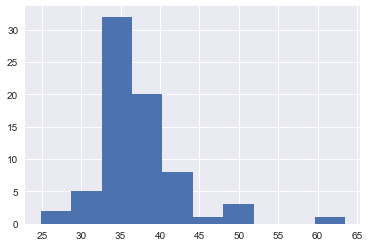

In [131]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.hist(df2.ix[df2.grid_id==2,].time_cost)

配送时长直方图

(array([ 55.,  10.,   2.,   2.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([ 0.     ,  0.02956,  0.05912,  0.08868,  0.11824,  0.1478 ,
         0.17736,  0.20692,  0.23648,  0.26604,  0.2956 ]),
 <a list of 10 Patch objects>)

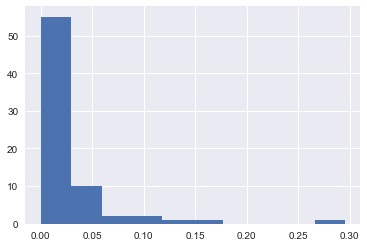

In [132]:
plt.hist(df2.ix[df2.grid_id==2,].overtime_rate)

超时率直方图

(array([  3.,   3.,  14.,  16.,  15.,   8.,   9.,   2.,   1.,   1.]),
 array([ 0.102  ,  0.16822,  0.23444,  0.30066,  0.36688,  0.4331 ,
         0.49932,  0.56554,  0.63176,  0.69798,  0.7642 ]),
 <a list of 10 Patch objects>)

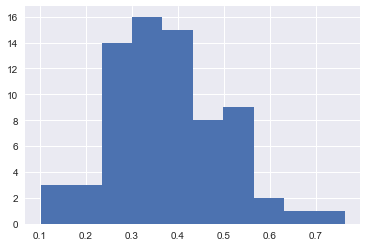

In [133]:
plt.hist(df2.ix[df2.grid_id==2,].overtime_rate_40)

40分钟超时率直方图

(array([ 41.,  17.,   8.,   3.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([ 0.     ,  0.00336,  0.00672,  0.01008,  0.01344,  0.0168 ,
         0.02016,  0.02352,  0.02688,  0.03024,  0.0336 ]),
 <a list of 10 Patch objects>)

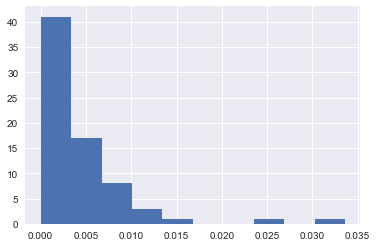

In [134]:
plt.hist(df2.ix[df2.grid_id==2,].cancel_rate)

异常取消率的直方图

去除异常值

In [135]:
df3=df2.ix[(
           (df2.cancel_rate<(df2.cancel_rate).quantile(0.95))&
           (df2.overtime_rate<(df2.overtime_rate).quantile(0.95))&
           (df2.pressure_ratio_75>0.1)
           ),]

In [136]:
df3.shape

(234192, 9)

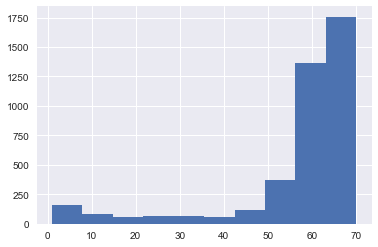

In [137]:
%matplotlib inline
df3.groupby(['grid_id','city']).size().hist()

In [138]:
anomal_grids1 = df.groupby(['grid_id', 'city']).agg({'order_date': len})
#anomal_grids= anomal_grids[anomal_grids.order_date == 72]
#grids = pd.unique(anomal_grids.index.get_level_values('grid_id'))
#df1 = df[df['grid_id'].isin(grids)] 

In [139]:
anomal_grids1=anomal_grids[anomal_grids.order_date>=20]
grids1=pd.unique(anomal_grids1.index.get_level_values('grid_id'))
df4=df3[df3.grid_id.isin(grids1)]

In [140]:
anomal_grids2=anomal_grids1[anomal_grids1.order_date<20]
anomal_grids2.shape

(0, 1)

去除异常值和空值以后的网格观测天数直方图

In [141]:
from sklearn.linear_model import LinearRegression
df4.reset_index(inplace=True)
def df5_lm_std(x):
    pressure = pd.DataFrame(df4.ix[x.index].pressure_ratio_75)
    lm = LinearRegression().fit(pressure,x)
    threshold = x.quantile(0.85)    
    return (threshold-lm.intercept_)/lm.coef_[0]
result1=df4.groupby(['city','grid_id']).agg({'overtime_rate_40': df5_lm_std,
                         'overtime_rate': df5_lm_std,
                         'cancel_rate': df5_lm_std,
                         'time_cost': df5_lm_std})
result1



/Users/ymzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


overtime_rate_40  overtime_rate  cancel_rate  time_cost
city  grid_id                                                         
三亚市   1859             0.697294       0.751078    -0.841423   0.673414
      2027             0.439889       0.428677     1.182973   0.428552
      2049             0.451145       0.649757          NaN   0.440396
      2262             0.587306       0.647846     0.814983   0.565233
      13809            0.609075       0.632924    -0.035992   0.574225
上海市   34              -3.965201       0.315347          NaN   5.423083
      37               0.824377       0.886035     9.510436   0.827310
      38               0.833859       0.676216    -0.474050   0.785537
      39               0.913446       0.744287     1.020576   0.877771
      40               0.916881       1.111277     1.922417   0.822945
      42               0.726536       0.730911    -4.127500   0.668126
      43               0.704300       0.763442     0.422465   0.707465
      44               0.783672       0.743810     0.090391   0.752393
      45               1.102573       1.097631     1.447944   1.151706
      58               1.143688       0.240148          NaN   0.494214
      84               0.739058       0.627271     0.903099   0.683811
      85               1.053530       1.175096     1.584897   1.027881
      186              0.451491            NaN          NaN   0.318720
      374              0.524361       0.580540     0.847251   0.510344
      394              0.830864       1.479843          NaN   0.864687
      410              0.634924       0.692430     0.179492   0.623408
      1230            -0.627989       0.441819          NaN   1.415389
      1312             0.226006            NaN          NaN   0.197218
      1335             0.541802            NaN          NaN   0.482223
      1531             3.939235            NaN          NaN   0.710353
      2674             0.545075            NaN          NaN   0.518023
      2727                  NaN            NaN          NaN   0.365580
      2741             1.060164            NaN          NaN   0.656409
      2930             0.359135            NaN          NaN   0.359135
      3009             0.792134            NaN          NaN   0.737556
...                         ...            ...          ...        ...
青岛市   8365             0.622884       0.594888     0.852091   0.620128
      8379             0.759515       0.741019     1.400400   0.728253
      8391             0.703963       0.891273    -0.069488   0.721473
      8430             0.468744       0.453147    -0.028796   0.452275
      8436             0.425234       0.383984    -1.134170   0.399088
      8445             0.439656       0.415357     1.207202   0.419364
      8522             1.162831       0.883144    -1.990553   0.973984
      8549             0.990798       1.466100     1.962678   1.003336
      8961             0.595246       0.681949    -2.578473   0.580113
      9087             0.591114       0.718713     4.001889   0.587540
      9094             0.979189      -0.832916     0.211484   0.646694
      9147             0.538458       0.650890          NaN   0.541330
      10743            0.671264       0.710317     0.938989   0.673200
      10831            0.795368       6.472165     2.544391   0.739959
      13591            0.494017       0.530606     2.671764   0.491965
      13834            0.514961       0.440088     1.030476   0.482426
      13979            0.590396       0.561745     0.724812   0.542582
      15588            0.523396       0.683509     0.150416   0.485942
齐齐哈尔市 1283             0.439341       0.568945     0.601445   0.414030
      1292             0.647456       0.550411     0.147286   0.615736
      1520             0.507871       0.668686          NaN   0.508736
      1588             0.686127       0.683924     0.894645   0.663278
      2679             0.584433       0.630850   -21.954903   0.584897
      4921             0.531548       0

In [142]:
writer = pd.ExcelWriter('result1.xlsx', engine='xlsxwriter')
result1.to_excel(writer, sheet_name='Sheet0')

In [143]:
df4_85=df4.ix[(df4.city=='上海市')&(df4.grid_id==85),]

In [144]:
df4['pressure_ratio1']=round(df4.pressure_ratio_75,1)
df4_85['pressure_ratio1']=round(df4_85.pressure_ratio_75,1)
df4['pressure_ratio1'] = df4['pressure_ratio1'].astype('category')
df4_85['pressure_ratio1'] = df4_85['pressure_ratio1'].astype('category')

/Users/ymzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ymzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


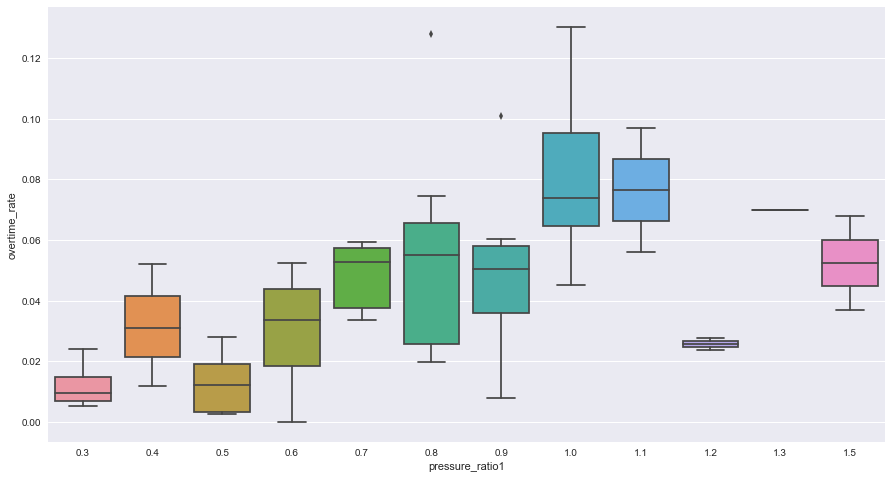

In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='overtime_rate',data=df4_85)

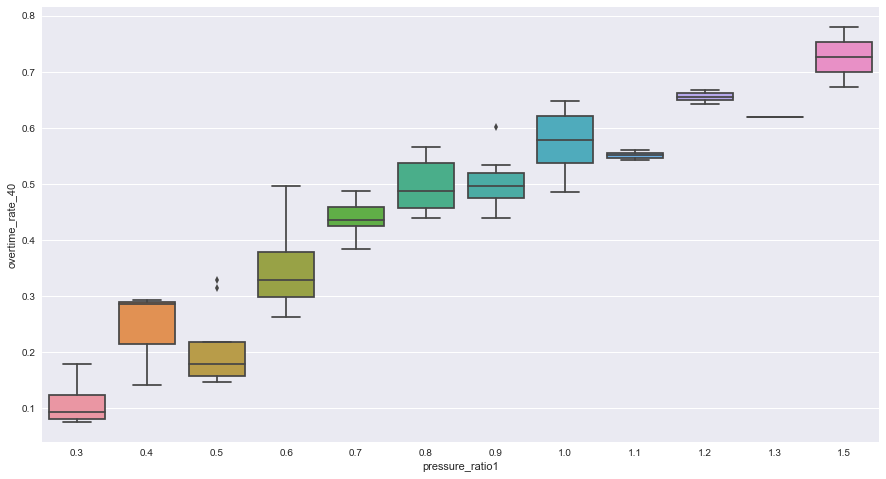

In [146]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='overtime_rate_40',data=df4_85)

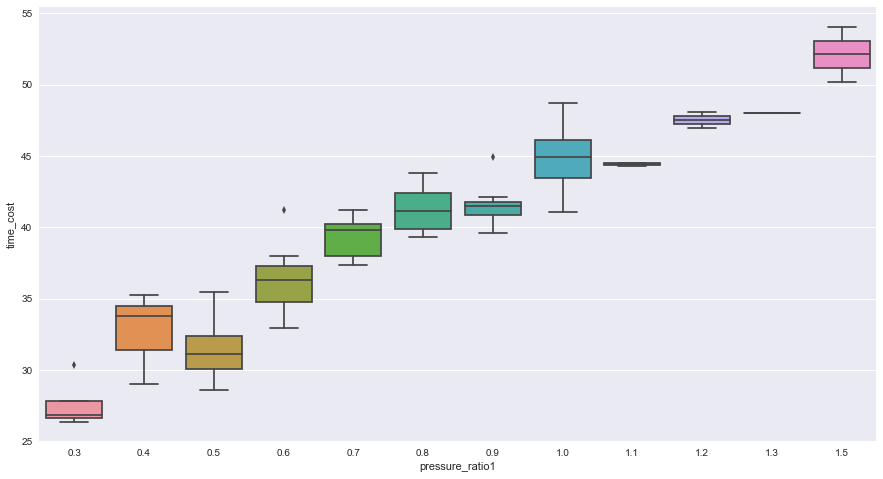

In [147]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='time_cost',data=df4_85)

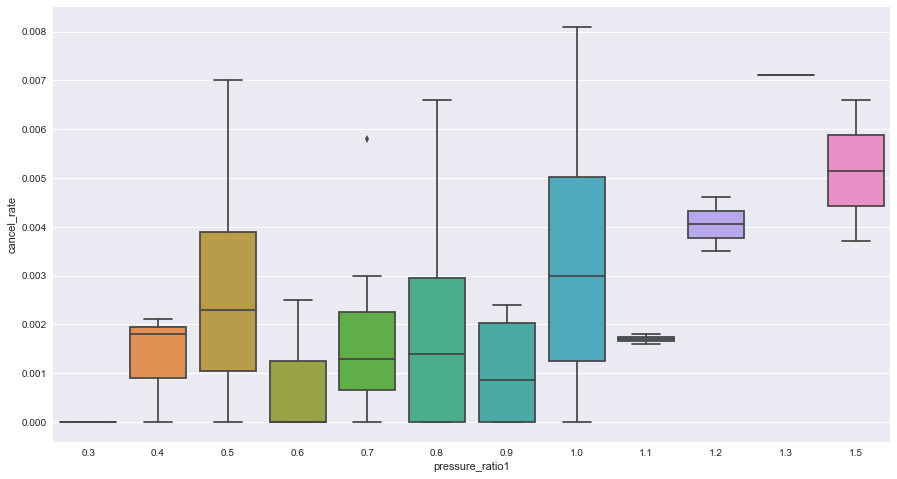

In [148]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='cancel_rate',data=df4_85)

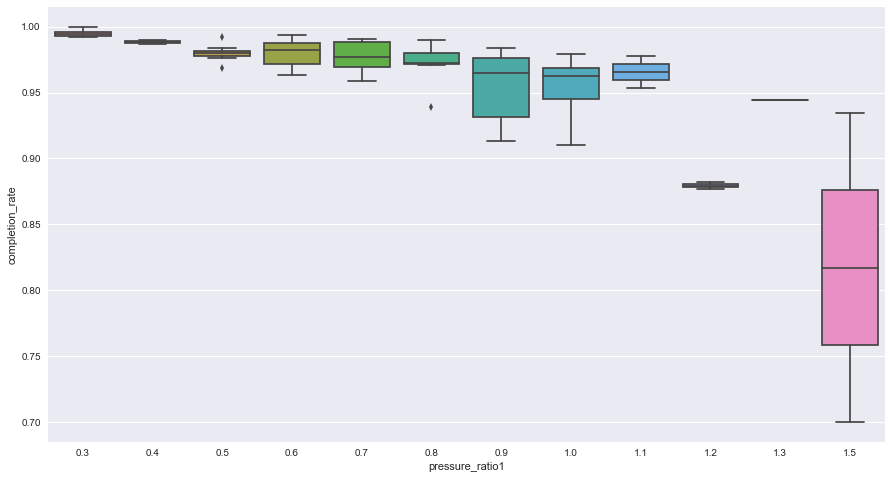

In [149]:
plt.subplots(figsize=(15,8))
sns.boxplot(x="pressure_ratio1", y='completion_rate',data=df4_85)

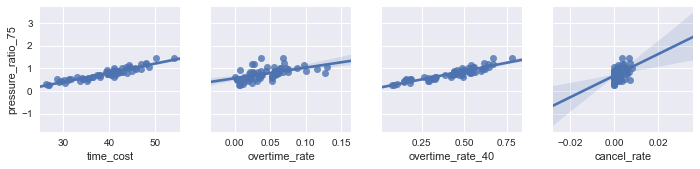

In [150]:
sns.pairplot(df4_85, x_vars=['time_cost','overtime_rate','overtime_rate_40','cancel_rate'], y_vars='pressure_ratio_75', kind='reg')

** 求的回归的R square **

In [151]:

from sklearn.metrics import r2_score, f1_score
def f(X):  
    feature_cols=['time_cost']
    linreg=LinearRegression()
    a=X[feature_cols]
    b=X.pressure_ratio_75
    linreg.fit(a,b)
    return linreg.score(a, b, sample_weight=None)

In [152]:
df4.groupby(['city','grid_id']).apply(f)

city   grid_id
三亚市    1859       0.601798
       2027       0.485145
       2049       0.445878
       2262       0.493076
       13809      0.751658
上海市    34         0.003392
       37         0.877203
       38         0.774795
       39         0.801013
       40         0.466413
       42         0.545765
       43         0.793366
       44         0.890115
       45         0.921464
       58         0.149199
       84         0.680716
       85         0.872864
       186        0.167915
       374        0.719391
       394        0.362915
       410        0.725775
       1230       0.003608
       1312       0.295826
       1335       0.983051
       1531       0.308364
       2674       0.456809
       2727       1.000000
       2741       0.307192
       2930       1.000000
       3009       0.404031
                    ...   
青岛市    8365       0.623978
       8379       0.647051
       8391       0.460998
       8430       0.618407
       8436       0.651679
       8445  

In [153]:
def partition(x):
    if x < 0.5:
        return 1
    elif x >= 0.4 and x < 1:
        return 2
    else:
        return 3

df4_85['cluster'] = df4_85.pressure_ratio_75.map(partition)

/Users/ymzhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


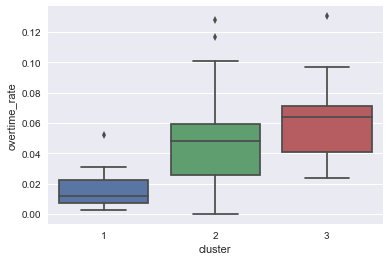

In [154]:
sns.boxplot(x="cluster", y='overtime_rate',data=df4_85)

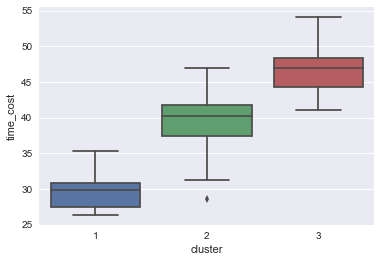

In [155]:
sns.boxplot(x="cluster", y='time_cost',data=df4_85)